In [1]:
# importing libraries
import Phonon_Number as pn
import parameters as params

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import clear_output
from scipy.io import savemat, loadmat
from scipy.optimize import minimize
from scipy.special import gamma as gamma_function

In [2]:
def calculate_error(parameters):
    '''
    Returns absolute log error between phonon(t) and fit(t)    
    '''
    decay_rate, beta = parameters

    fit = pn.stretched_exponential(time, decay_rate, beta)
    error = np.sum(np.abs(np.log10(phonon) - np.log10(fit)))/len(phonon)
    
    return error

def save_data():
    polariton_phonon_decay_thermal_N_40 = {'T2' : T2,
                                           'pump' : pump,
                                           'nth' : nth,
                                           'g' : g,
                                           'temperature' : temperature,
                                           'gamma' : gamma,
                                           'omega_m' : omega_m,
                                           'N' : N,
                                           'decay_rate' : decay_rate,
                                           'best_fit_error': best_fit_error,
                                           'beta_array': beta_array,
                                           'phonon_ss': phonon_ss,
                                           'phonon_number_array': phonon_number_array,
                                           'best_fit_array': best_fit_array,
                                           'average_error':average_error,
                                           't_final_array': t_final_array
                                          }
            
    savemat("./data files/polariton_phonon_decay_thermal_N_40.mat", polariton_phonon_decay_thermal_N_40)

In [3]:
'''
Define and initialize parameters
'''

# Import parameters
G, omega_m, g, gamma, temperature, nth = params.polariton_params()

N = 40                                    # truncation of phonon number basis in qutip

gamma = omega_m*10**-7                      # in MHz
dephasing = 0                               # in MHz
incoherent_pump = 0                         # in MHz

print('nth =', nth)

initial_state = pn.calculate_initial_state(N, nth)
print('initial phonons = ', pn.calculate_phonon_number(initial_state, N))

data_points = 30
T2 = np.logspace(-1,1,data_points)*g
pump = np.logspace(-1,1,data_points)*g

# Defining arrays to store data
decay_rate = np.zeros((len(pump), len(T2)))
beta_array = np.zeros((len(pump), len(T2)))
t_final_array = np.zeros((len(pump), len(T2)))
phonon_number_array = np.zeros((len(pump), len(T2), 5000))
phonon_ss = np.zeros((len(pump), len(T2)))

best_fit_error = np.zeros((len(pump), len(T2)))
best_fit_array = []
average_error = np.zeros((len(pump), len(T2)))

nth = 5.00000686423051
initial phonons =  4.9727729721705805


In [ ]:
'''
Import data from datasets
'''

polariton_phonon_decay_thermal = loadmat('./data files/polariton_phonon_decay_thermal_N_40.mat')
phonon_number_array = polariton_phonon_decay_thermal['phonon_number_array']
t_final_array = polariton_phonon_decay_thermal['t_final_array']
phonon_ss = polariton_phonon_decay_thermal['phonon_ss']

### Calculate and store phonon number as a function of time

In [ ]:
'''
Iterate over T2 and pump arrays to calculate phonon_number(t) and t_final and store in respective arrays
'''

for i in range(len(pump)):
    for j in range(len(T2)):
        
        T1 = T2[j]
            
        if(i%10 == 0 or j%10 == 0):                 # saving data in between
            save_data()
            
        if(t_final_array[i,j] == 0):                # run if the index has not been initialized
        
            t_final = max(5000/(T2[j]), 1000)       # time for simulation for QD case (in ns)
        
            loop_again = True                       # check for looping again
            counter = 0                             # count the number of loops for one set of values of pump and T2
            print('index at: (', i,j, ')') 
            
            while(loop_again):    # loop until steadystate is verified by the function check_ss()
                counter = counter + 1
                
                # Define Hamiltonian and collapse operators
                Hamiltonian, collapse_ops = pn.polariton_system(g, pump[i], T2[j], gamma, dephasing, incoherent_pump, nth, N)
                
                # Create time array
                time = np.linspace(0, t_final, 5000)
                
                # Simulate the system to calculate phonon(t)
                phonon = pn.master_eq_solver(Hamiltonian, initial_state, time, collapse_ops, N)
                
                # Calculate the steady state phonon number
                phonon_ss[i,j] = pn.steady_state_phonon(Hamiltonian, collapse_ops, N)
                
                # check for steadystate
                check = pn.check_ss(phonon, phonon_ss[i,j])

                # check for steadystate
                check = pn.check_ss(phonon, phonon_ss[i,j])
                
                if(check):                      # if true, store data
                    phonon_number_array[i,j,:] = phonon
                    t_final_array[i,j] = t_final
                    
                    loop_again = False           # break the while loop
                else:                            # else, increase time for simulation and run again
                    t_final = t_final*3          # if check failed, increase time for simulation and run again
                
        
            # plot fits and formatting
            plt.figure()
            plt.title('counter = {}, index: (', i,j,')'.format(counter), fontsize = 12)
            plt.semilogy(time, phonon, label = 'phonon #', linewidth = 4)
            fig = plt.gcf()
            fig.set_size_inches((10, 5), forward=False)
            plt.xticks(fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.savefig('./polariton_phonon_decay_thermal/Plot({}, {})'.format(i,j))
            plt.close()

save_data()

### Fitting extended exponential function to phonon number

In [4]:
'''
Calculating the best fist and subsequently the corresponding decay rate and beta values.

- Using scipy.optimize.minmize for fitting
- Initial condition for an index tuple is the decay rate of the previous index; decay_rate_init[i,j] = decay_rate[i,j-1].
-- When j = 0; decay_rate_init[i,j] = decay_rate[i-1,0]
-- When i = 0 = j; decay_rate_init[0,0] = 10**-2
-- Tolerance is set to 10**-10

'''

for i in range(len(pump)):
    
    if(i == 0):
        decay_rate_init = 10**-2
    else:
        decay_rate_init = decay_rate[i-1, 0]
    
    for j in range(len(T2)):
        
        print('(',i,j,'); oldie error = ', average_error[i,j])
        
        # Initialize arrays
        phonon = phonon_number_array[i,j]
        time = np.linspace(0, t_final_array[i,j], 5000)
        
        # Calculating the value of the variable index
        index = pn.find_index(phonon, phonon_ss[i,j])
        
        # Shrink the arrays for fitting
        time = time[:index]
        phonon = phonon[:index]
        
        # Calculate best fit using scipy.minimize
        result_best_fit = minimize(calculate_error, x0 = [decay_rate_init, 1], bounds = [(10**-4, 10**2), (0, 1)], tol = 10**-10)
        
        # Substitute values
        decay_rate[i,j] = result_best_fit.x[0]
        beta_array[i,j] = result_best_fit.x[1]
        best_fit_error[i,j] = result_best_fit.fun
        
        # Create best fit array using best fit parameters and store
        best_fit = pn.stretched_exponential(time, decay_rate[i,j], beta_array[i,j], phonon_ss[i,j], nth)
        best_fit_array.append(best_fit)
        
        # Calculate average error
        average_error[i,j] = pn.calculate_average_error(best_fit, phonon)

        print('average error = ', average_error[i,j])
        
        counter = 'post_processing'
        
        # Re-initialize the initial condition for decay_rate for scipy.minimize
        decay_rate_init = decay_rate[i,j]
        
        plt.figure()
        plt.title('decay_rate = {:1f}, counter = {}, average_error = {:1f}, beta = {:1f}'\
                  .format(decay_rate[i,j], counter, average_error[i,j], beta_array[i,j]), fontsize = 10)
        plt.semilogy(np.linspace(0, t_final_array[i,j], 5000), phonon_number_array[i,j], label = 'phonon #', linewidth = 4)
        plt.semilogy(time, best_fit, label = 'phonon fit', linewidth = 3, linestyle = '--', color = '#ff7f0e')
        legend = plt.legend(fontsize = 20, frameon = False)
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        fig = plt.gcf()
        fig.set_size_inches((10, 5), forward=False)
        plt.savefig('./polariton_phonon_decay_thermal/Plot({}, {})'.format(i,j))
        plt.close()

        print('')

decay_rate = decay_rate*beta_array/gamma_function(1/beta_array)
save_data()

( 0 0 ); oldie error =  0.0
average error =  0.001192978333991886

( 0 1 ); oldie error =  0.0
average error =  0.0017019314227260725

( 0 2 ); oldie error =  0.0
average error =  0.0023982496579140118

( 0 3 ); oldie error =  0.0
average error =  0.003327177492572421

( 0 4 ); oldie error =  0.0
average error =  0.001511036665454062

( 0 5 ); oldie error =  0.0
average error =  0.0020155607961385917

( 0 6 ); oldie error =  0.0
average error =  0.002626145926083555

( 0 7 ); oldie error =  0.0
average error =  0.003331990798589738

( 0 8 ); oldie error =  0.0
average error =  0.0041039266006865464

( 0 9 ); oldie error =  0.0
average error =  0.004886389129011111

( 0 10 ); oldie error =  0.0
average error =  0.0055985878622867805

( 0 11 ); oldie error =  0.0
average error =  0.005344578777844053

( 0 12 ); oldie error =  0.0
average error =  0.004726598225649799

( 0 13 ); oldie error =  0.0
average error =  0.0039023415769697044

( 0 14 ); oldie error =  0.0
average error =  0.0029


( 4 1 ); oldie error =  0.0
average error =  0.008481597207880076

( 4 2 ); oldie error =  0.0
average error =  0.010480574907587073

( 4 3 ); oldie error =  0.0
average error =  0.012686220345139733

( 4 4 ); oldie error =  0.0
average error =  0.015044089504338894

( 4 5 ); oldie error =  0.0
average error =  0.017493579696952224

( 4 6 ); oldie error =  0.0
average error =  0.019945444689898464

( 4 7 ); oldie error =  0.0
average error =  0.0074358699886162664

( 4 8 ); oldie error =  0.0
average error =  0.008143533617307491

( 4 9 ); oldie error =  0.0
average error =  0.008718809228642672

( 4 10 ); oldie error =  0.0
average error =  0.009102748920567047

( 4 11 ); oldie error =  0.0
average error =  0.009233108218821097

( 4 12 ); oldie error =  0.0
average error =  0.009054060704366592

( 4 13 ); oldie error =  0.0
average error =  0.008524937646523045

( 4 14 ); oldie error =  0.0
average error =  0.007670522314654494

( 4 15 ); oldie error =  0.0
average error =  0.0060951


( 8 3 ); oldie error =  0.0
average error =  0.011073003206579727

( 8 4 ); oldie error =  0.0
average error =  0.012240442128482805

( 8 5 ); oldie error =  0.0
average error =  0.013434713374755727

( 8 6 ); oldie error =  0.0
average error =  0.014648155187107338

( 8 7 ); oldie error =  0.0
average error =  0.015851043174150047

( 8 8 ); oldie error =  0.0
average error =  0.017006616096659134

( 8 9 ); oldie error =  0.0
average error =  0.01806411825303769

( 8 10 ); oldie error =  0.0
average error =  0.018942815823143663

( 8 11 ); oldie error =  0.0
average error =  0.019569903594108644

( 8 12 ); oldie error =  0.0
average error =  0.0198348605081306

( 8 13 ); oldie error =  0.0
average error =  0.019643955404573143

( 8 14 ); oldie error =  0.0
average error =  0.018910626748602548

( 8 15 ); oldie error =  0.0
average error =  0.016263214916026097

( 8 16 ); oldie error =  0.0
average error =  0.012425419448068832

( 8 17 ); oldie error =  0.0
average error =  0.009152304


( 12 5 ); oldie error =  0.0
average error =  0.006963196796714298

( 12 6 ); oldie error =  0.0
average error =  0.007743694244666446

( 12 7 ); oldie error =  0.0
average error =  0.008573752330729123

( 12 8 ); oldie error =  0.0
average error =  0.009416214587564668

( 12 9 ); oldie error =  0.0
average error =  0.010253218747604036

( 12 10 ); oldie error =  0.0
average error =  0.011006847689179079

( 12 11 ); oldie error =  0.0
average error =  0.011679158992423024

( 12 12 ); oldie error =  0.0
average error =  0.012139479949574013

( 12 13 ); oldie error =  0.0
average error =  0.012356799898000549

( 12 14 ); oldie error =  0.0
average error =  0.012254026317999243

( 12 15 ); oldie error =  0.0
average error =  0.01084671294392649

( 12 16 ); oldie error =  0.0
average error =  0.008573735102241957

( 12 17 ); oldie error =  0.0
average error =  0.0064877977496932875

( 12 18 ); oldie error =  0.0
average error =  0.0046967121341399565

( 12 19 ); oldie error =  0.0
average


( 16 4 ); oldie error =  0.0
average error =  0.0017168869976126224

( 16 5 ); oldie error =  0.0
average error =  0.0019468337807683894

( 16 6 ); oldie error =  0.0
average error =  0.00218759389368613

( 16 7 ); oldie error =  0.0
average error =  0.002443962967645197

( 16 8 ); oldie error =  0.0
average error =  0.002701288531548876

( 16 9 ); oldie error =  0.0
average error =  0.002943960339872077

( 16 10 ); oldie error =  0.0
average error =  0.0031782581006428827

( 16 11 ); oldie error =  0.0
average error =  0.0033836689532954402

( 16 12 ); oldie error =  0.0
average error =  0.0035517637588876193

( 16 13 ); oldie error =  0.0
average error =  0.0036646987394072413

( 16 14 ); oldie error =  0.0
average error =  0.0037013060863665364

( 16 15 ); oldie error =  0.0
average error =  0.003382087228243612

( 16 16 ); oldie error =  0.0
average error =  0.0027623367568424206

( 16 17 ); oldie error =  0.0
average error =  0.002187741222747307

( 16 18 ); oldie error =  0.0
av


( 20 3 ); oldie error =  0.0
average error =  0.0006367050261025213

( 20 4 ); oldie error =  0.0
average error =  0.0006879794760448139

( 20 5 ); oldie error =  0.0
average error =  0.0007522165586875787

( 20 6 ); oldie error =  0.0
average error =  0.0008174529680816296

( 20 7 ); oldie error =  0.0
average error =  0.0008879780839052625

( 20 8 ); oldie error =  0.0
average error =  0.0009689144148960395

( 20 9 ); oldie error =  0.0
average error =  0.001061193879431929

( 20 10 ); oldie error =  0.0
average error =  0.001169706504735858

( 20 11 ); oldie error =  0.0
average error =  0.001290336326878212

( 20 12 ); oldie error =  0.0
average error =  0.0014427565518303454

( 20 13 ); oldie error =  0.0
average error =  0.0016261724486984455

( 20 14 ); oldie error =  0.0
average error =  0.0018513824156768993

( 20 15 ); oldie error =  0.0
average error =  0.001965827965723167

( 20 16 ); oldie error =  0.0
average error =  0.001965420558309999

( 20 17 ); oldie error =  0.0
a


( 24 1 ); oldie error =  0.0
average error =  0.000364220294273795

( 24 2 ); oldie error =  0.0
average error =  0.0003964221064716508

( 24 3 ); oldie error =  0.0
average error =  0.00042918878143853714

( 24 4 ); oldie error =  0.0
average error =  0.00046225691100797145

( 24 5 ); oldie error =  0.0
average error =  0.0004955443963343718

( 24 6 ); oldie error =  0.0
average error =  0.0005297499941436069

( 24 7 ); oldie error =  0.0
average error =  0.0005656360709242975

( 24 8 ); oldie error =  0.0
average error =  0.0006006657080320566

( 24 9 ); oldie error =  0.0
average error =  0.0006395979266943548

( 24 10 ); oldie error =  0.0
average error =  0.0006782570177117649

( 24 11 ); oldie error =  0.0
average error =  0.0007192140748688066

( 24 12 ); oldie error =  0.0
average error =  0.0007664981690313317

( 24 13 ); oldie error =  0.0
average error =  0.0008169439933510852

( 24 14 ); oldie error =  0.0
average error =  0.0008727601596493235

( 24 15 ); oldie error =  0


( 27 29 ); oldie error =  0.0
average error =  0.0006989062313258345

( 28 0 ); oldie error =  0.0
average error =  0.00020996222945449792

( 28 1 ); oldie error =  0.0
average error =  0.00022072015292912912

( 28 2 ); oldie error =  0.0
average error =  0.00023304939247842979

( 28 3 ); oldie error =  0.0
average error =  0.00024893977113087145

( 28 4 ); oldie error =  0.0
average error =  0.00026869994805352475

( 28 5 ); oldie error =  0.0
average error =  0.0002911410198594461

( 28 6 ); oldie error =  0.0
average error =  0.0003141601932343983

( 28 7 ); oldie error =  0.0
average error =  0.0003406603231992965

( 28 8 ); oldie error =  0.0
average error =  0.00036860351046591407

( 28 9 ); oldie error =  0.0
average error =  0.0003989372438387584

( 28 10 ); oldie error =  0.0
average error =  0.00042856142136035746

( 28 11 ); oldie error =  0.0
average error =  0.00046377965697493446

( 28 12 ); oldie error =  0.0
average error =  0.0004998262917272287

( 28 13 ); oldie erro

### Plot

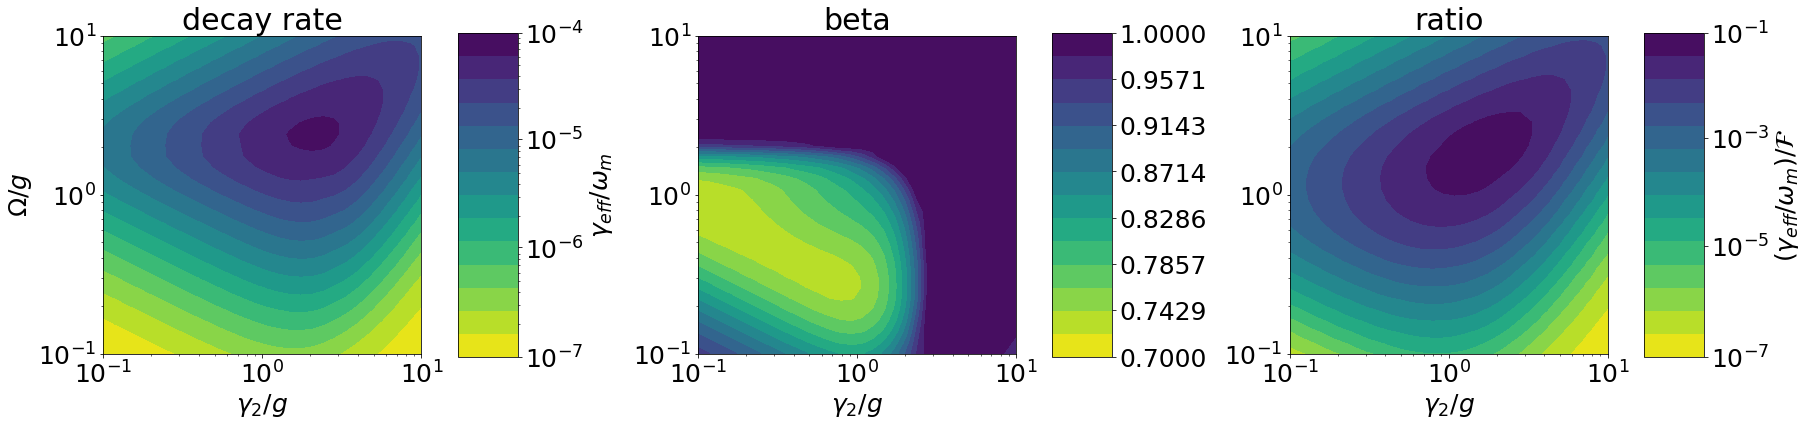

In [6]:
fig = plt.figure(constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=1)

fig.add_subplot(spec[0, 0])
[X,Y] = np.meshgrid(T2/(g),pump/(g)) # define X,Y for contour plot
levels = np.logspace(-7,-4,15) # finetune gradation in contour plot
locator = ticker.LogLocator(base=10)
plt.contourf(X,Y, decay_rate/(omega_m), locator=ticker.LogLocator(), levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(ticks=[10**-7, 10**-6, 10**-5, 10**-4], aspect = 15, shrink = 0.5)
cbar.ax.tick_params() 
cbar.set_label('$\gamma_{eff}/\omega_m$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\gamma_2/g$')
plt.xticks()
plt.yticks()
plt.ylabel('$\Omega/g$')
plt.title('decay rate')
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')

fig.add_subplot(spec[0, 1])
levels = np.linspace(0.7,1,15) # finetune gradation in contour plot
plt.contourf(X,Y, beta_array, levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(aspect = 15, shrink = 0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\gamma_2/g$')
plt.xticks()
plt.yticks()
# plt.ylabel('$\Omega/g$')
plt.title('beta')
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')


fig.add_subplot(spec[0, 2])
levels = np.logspace(-7,-1,15) # finetune gradation in contour plot
plt.contourf(X,Y, decay_rate*nth/(omega_m*phonon_ss), locator=ticker.LogLocator(), levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(aspect = 15, shrink = 0.5, ticks = [10**-7, 10**-5, 10**-3, 10**-1, 10**1])
cbar.ax.tick_params()
# cbar.ax.set_yticklabels([0.001, 0.1, 10, 1000])
cbar.set_label('$(\gamma_{eff}/\omega_m)/\mathcal{F}$')
plt.xscale('log')
plt.yscale('log')
plt.xticks()
plt.yticks()
# plt.ylabel('$\Omega/g$')
plt.xlabel('$\gamma_2/g$')
plt.title('ratio')
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')
plt.rcParams.update({'font.size': 25})


fig = plt.gcf()
fig.set_size_inches((25, 9))

# plt.savefig('decay_polariton.png')

### Manuscript Plot

In [2]:
'''
Import data
'''

polariton_phonon_decay_thermal = loadmat('./data files/polariton_phonon_decay_thermal_N_40.mat')
phonon_number_array = polariton_phonon_decay_thermal['phonon_number_array']
best_fit_array = polariton_phonon_decay_thermal['best_fit_array'][0]
t_final_array = polariton_phonon_decay_thermal['t_final_array']
phonon_ss = polariton_phonon_decay_thermal['phonon_ss']
decay_rate = polariton_phonon_decay_thermal['decay_rate']

pump = polariton_phonon_decay_thermal['pump'][0]
T2 = polariton_phonon_decay_thermal['T2'][0]
g = int(polariton_phonon_decay_thermal['g'])
omega_m = polariton_phonon_decay_thermal['omega_m'][0]
nth = polariton_phonon_decay_thermal['nth'][0]

In [3]:
'''
Prepare arrays to plot data. Import phonon number arrays, best fit arrays from stored data. Each array is called
through the index tuple (pump, T2): (i,j)
'''

# Phonon_1
i, j = 0, 15
phonon_1 = phonon_number_array[i,j]
phonon_best_fit_1 = best_fit_array[i*30+j][0]
time_1 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_2
i, j = 19, 15
phonon_2 = phonon_number_array[i,j]
phonon_best_fit_2 = best_fit_array[i*30+j][0]
time_2 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_3
i, j = 29, 15
phonon_3 = phonon_number_array[i,j]
phonon_best_fit_3 = best_fit_array[i*30+j][0]
time_3 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_4
i, j = 15, 0
phonon_4 = phonon_number_array[i,j]
phonon_best_fit_4 = best_fit_array[i*30+j][0]
time_4 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_5
i, j = 15, 19
phonon_5 = phonon_number_array[i,j]
phonon_best_fit_5 = best_fit_array[i*30+j][0]
time_5 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_6
i, j = 15, 29
phonon_6 = phonon_number_array[i,j]
phonon_best_fit_6 = best_fit_array[i*30+j][0]
time_6 = np.linspace(0, t_final_array[i,j], 5000)

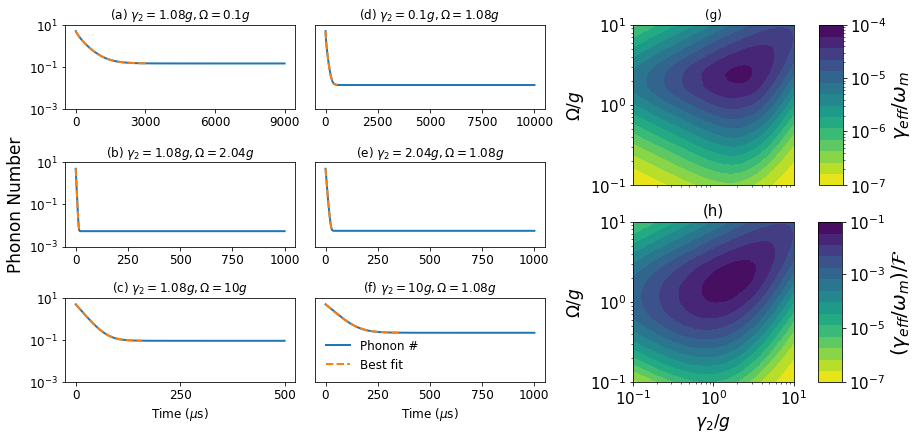

In [4]:
'''
Plot!!
'''
ymax = phonon_1[0] + 1

fig = plt.figure(constrained_layout=True)
spec = fig.add_gridspec(ncols=4, nrows=6)

fig.add_subplot(spec[0:2, 0])
plt.semilogy(time_1, phonon_1, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_1[:len(phonon_best_fit_1)], phonon_best_fit_1, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(a) $\gamma_2 = 1.08g, \Omega = 0.1g$', fontsize = 12)
plt.xticks([0, 3000, 6000, 9000], fontsize = 12)
plt.yticks([10, 0.1, 0.001], fontsize = 12)

fig.add_subplot(spec[2:4, 0])
plt.ylabel('Phonon Number', fontsize = 17)
plt.semilogy(time_2, phonon_2, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_2[:len(phonon_best_fit_2)], phonon_best_fit_2, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(b) $\gamma_2 = 1.08g, \Omega = 2.04g$', fontsize = 12)
# legend = plt.legend(fontsize = 10, frameon = False)
plt.xticks([0, 250, 500, 750, 1000], fontsize = 12)
plt.yticks([10, 0.1, 0.001], fontsize = 12)

fig.add_subplot(spec[4:6, 0])
plt.semilogy(time_3, phonon_3, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_3[:len(phonon_best_fit_3)], phonon_best_fit_3, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(c) $\gamma_2 = 1.08g, \Omega = 10g$', fontsize = 12)
plt.xlabel('Time ($\mu$s)', fontsize = 12)
# legend = plt.legend(fontsize = 10, frameon = False)
plt.xticks([0, 250, 500], fontsize = 12)
plt.yticks([10, 0.1, 0.001], fontsize = 12)

fig.add_subplot(spec[0:2, 1])
plt.semilogy(time_4, phonon_4, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_4[:len(phonon_best_fit_4)], phonon_best_fit_4, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(d) $\gamma_2 = 0.1g, \Omega = 1.08g$', fontsize = 12)
# legend = plt.legend(fontsize = 10, frameon = False)
plt.xticks([0, 2500, 5000, 7500, 10000], fontsize = 12)
plt.yticks([])
plt.ylim(top = 10, bottom=0.001)

fig.add_subplot(spec[2:4, 1])
# plt.ylabel('Phonon Number', fontsize = 10)
plt.semilogy(time_5, phonon_5, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_5[:len(phonon_best_fit_5)], phonon_best_fit_5, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(e) $\gamma_2 = 2.04g, \Omega = 1.08g$', fontsize = 12)
# legend = plt.legend(fontsize = 10, frameon = False)
plt.xticks([0, 250, 500, 750, 1000], fontsize = 12)
plt.yticks([])
# plt.ylim(top=ymax)
plt.ylim(top=10, bottom=0.001)

fig.add_subplot(spec[4:6, 1])
plt.semilogy(time_6, phonon_6, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_6[:len(phonon_best_fit_6)], phonon_best_fit_6, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(f) $\gamma_2 = 10g, \Omega = 1.08g$', fontsize = 12)
plt.xlabel('Time ($\mu$s)', fontsize = 12)
legend = plt.legend(fontsize = 12, frameon = False)
plt.xticks([0, 250, 500, 750, 1000], fontsize = 12)
plt.yticks([])
plt.ylim(top=10, bottom=0.001)

fig.add_subplot(spec[0:3, 2:3])
[X,Y] = np.meshgrid(pump/g,T2/g) # define X,Y for contour plot
levels = np.logspace(-7,-4,15) # finetune gradation in contour plot
locator = ticker.LogLocator(base=10)
plt.contourf(X,Y, decay_rate/(omega_m), locator=ticker.LogLocator(), levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(ticks=locator, aspect = 18, shrink = 1)
cbar.ax.tick_params(labelsize=15) 
cbar.set_label('$\gamma_{eff}/\omega_m$', fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.xticks([])
plt.yticks(fontsize = 15)
plt.ylabel('$\Omega/g$', fontsize = 17)
plt.title('(g)', fontsize = 12)
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')

fig.add_subplot(spec[3:6, 2:3])
levels = np.logspace(-7,-1,15) # finetune gradation in contour plot
plt.contourf(X,Y, decay_rate*nth/(omega_m*phonon_ss), locator=ticker.LogLocator(), levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(aspect = 18, shrink = 1, ticks = [10**-7, 10**-5, 10**-3, 10**-1])
cbar.ax.tick_params(labelsize=15) 
cbar.set_label('$(\gamma_{eff}/\omega_m)/\mathcal{F}$', fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('$\gamma_2/g$', fontsize = 17)
plt.ylabel('$\Omega/g$', fontsize = 17)
plt.title('(h)', fontsize = 15)
plt.xticks([10**-1, 1, 10], fontsize = 15)
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')

fig = plt.gcf()
fig.set_size_inches((16, 6), forward=False)

plt.savefig('polariton_decay_combined.png', dpi = 500)